<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">20th December, 2018</span>
</div><h1>RecDynapSE:</h1><h1>Layer using the DynapSE chip</h1>

This document illustrates how to use the `RecDynapSE` layer, that runs directly on the DynapSE chip.

##### Housekeeping and import statements


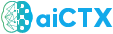

In [1]:
# - Import required modules and configure; set report style 

import os, sys
strToolboxPath = os.path.abspath("../../")
if strToolboxPath not in sys.path:
    sys.path.append(strToolboxPath)

# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

## Setup

<br>

### Connecting to Cortexcontrol

In order to work interface the DynapSE chip, this layer relies on `Cortexcontrol`. It can either be used from within the `Cortexcontrol` console or by via an `RPyC` connection. In order to run some examples from within this jupyter notebook, we will do the latter. For this we start `Cortexcontrol` and run the following commands in its console (not in this notebook):

<br>



### Using DynapseControl

The `RecDynapSE` layer uses a `DynapseControl` object to interact with `Cortexcontrol` (see .... for more details). You can either pass an existing `DynapseControl` object to the layer upon instantiation, or let the layer create such an object. Either way, it can be accessed via the layer's `controller` attribute.

<br>

## Import

In [2]:
# - Import recurrent RecDIAF layer
from NetworksPython.layers import RecDynapSE

<br>

## Instantiation
Some of the arguments that`RecDynapSE` objects are instantiated with are analogue to other `NetworksPython` objects, in partuclar recurrent layers such as `RecIAFTorch`, `RecIAFBrian` or `RecDIAF`. Others are more related to how the hardware is used:

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `mfWIn` | 2D-`ndarray`| - | Input weights (required) |
| `mfWRec` | 2D-`ndarray` | - | Recurrent weights (required) |
| `vnLayerNeuronIDs` | 1D-`ArrayLike` | `None` | IDs of the layer neurons |
| `vnVirtualNeuronIDs` | 1D-`ArrayLike` | `None` | IDs of the virtual (input) neurons |
| `tDt` | `float` | `2e-5` | Time step |
| `nMaxTrialsPerBatch` | `int` | `None` | Maximum number of trials in individual batch |
| `tMaqxBatchDur` | `float` | `None` | Maximum duration time of individual batch |
| `nMaxNumTimeSteps` | `int` | `None` | Maximum number of time steps in individual batch |
| `nMaxEventsPerBatch` | `int` | `None` | Maximum number of input Events during individual batch |
| `lInputCoreIDs` | `ArrayLike` | `[0]` | IDs of cores that receive input spikes |
| `nInputChipID` | `int` | 0 | Chip that receives input spikes |
| `lnClearCores` | `ArrayLike` | `None` | IDs of cores to be reset |
| `controller` | `DynapseControl` | `None` | `DynapseControl` instance |
| `strName` | `str` | "unnamed" | Layer name |

`mfWIn` and `mfWRec` are the input and recurrent weights and have to be provided as 2D-arrays. `mfWIn` determines the layer's dimensions `nSIzeIn` and `nSize`. `mfWRec` has to be of size `nSize` x `nSize`.

Inputs are sent to the chip through so-called virtual neurons. Each virtual neuron has an ID, just like a physical neuron. For this layer, each input channel corresponds to such a virtual neuron. 

You can choose which physical and virtual neurons are used for the layer by passing their IDs in `vnLayerNeuronIDs` and `vnVirtualNeuronIDs`, respectively. If these arguments are `None`, the neurons will be automatically allocated. (-rewrite the following part-)

Any input spike to the layer translates to a virtual neuron emitting a spike. On the chip, these spikes are treated like those of other neurons, so if a neuron is set up to listen to a neuron with the same ID as the firing virtual neuron, it will also receive spikes from the virtual neuron. Therefore the entries of `vnLayerNeuronIDs` should be different from any value in `vnVirtualNeuronIDs`. `vnLayerNeuronIDs` is a 1D-array-like object of integers between 0 and 4095, which are the IDs of the DynapSE neurons that are to be used for the layer. Their ordering corresponds to the weight matrices, i.e. the n-th entry of `vnLayerNeuronIDs` corresponds to the same neuron as the n-th column in `mfWIn`. `vnVirtualNeuronIDs` contains the IDs of the virtual neurons that act as the source of incoming spikes to the layer. They can go from 0 to 1023 and should be different from any of the IDs in `vnLayerNeuronIDs`.

`tDt` a positive `float` and corresponds to the smallest (nonzero) interval between events that are sent to the chip. It corresponds to the layer timesteps of other layers. Below, under "tDt Size" you can find some more thoughts on how to choose this value.

As for now it is not possible with this layer to stream events (input spikes) continuously to the DynapSE. Therefore a group of events, consisting is transferred to the hardware, temporarily stored there and finally forwareded to the neurons at the . played back. This number is limited. Therefore layer evolution takes place in batches, during each of which events are sent and then finally "played back" as spikes of the virtual neurons. (... continue here)


`strName` is a `str` that defines the layer's name. 

All of these values can be accessed and changed via `<Layer>.value`, where `<Layer>` is the instance of the layer.

<br>

## tDt size



<br>

## Evolution

The `evolve` method takes the standard arguments `tsInput`, `tDuration`, `nNumTimeSteps` and `bVerbose`, which is currently not being used. Evolution duration is determined by the usual rules. If `tsInput` is provided, it must be a `TSEvent` object.

Neurons will evolve and spike as described above. The method will return a `TSEvent` object containing the timings and IDs of the layer neurons' spikes. If there are spikes from neurons within the layer, that due to the spike delay would only be received after the end of the evolution period, they will be processed at the correct times during the next evolution.

<br>

## Resetting

As usual the layer's time and state can be reset by the `reset_time`, `reset_state` and `reset_all` methods. When resetting the state, `vState` is set to `vfVReset`. Additionally, spikes from the previous evolution time step do not have any effect on future evolutions.

<br>

## Internal methods

```
_prepare_input(
    tsInput: Optional[TSEvent] = None,
    tDuration: Optional[float] = None,
) -> (np.ndarray, float)
```
Called by evolve, which passes it its `tsInput` and `tDuration` arguments. `_prepare_input` will determine the correct evolution duration (which is always a multiple of `tDt`. It then returns the event times from `tsInput`,  the corresponding channel IDs, the evolution duration and the layer time after evolution.

<br>

## Class member overview

<br>

### Methods
| Method | Description |
|--------|-------------|
| `_prepare_input` | Extract input data, determine evolution duration |
| `evolve` | Evolve layer |
| `reset_all` | Reset neuron states and layer time|
| `reset_state` | Reset neuron states |
| `reset_time` | Reset layer time to 0 |
| `randomize_state` | Randomize neuron states to integer values within the value range. |
<i> Internal methods of parent class</i> `Layer` <i> are listed in corresponding documentation. </i>

<br>

### Attributes

Each argument that described in section Instantiation has a corresponding attribute that can be accessed by `<Layer>.<attribute>`, where `<Layer>` is the layer instance and `<attribute>` the argument name. Furthermore there are a few internal attributes:

| Attribute name | Description |
|----------------|-------------|
| `_heapRemainingSpikes` | Heap of tuples containing the time and source ID of spikes that have not been processed, yet. |
| `_mfWTotal` | 2D-`ndarray` of shape (`nSizeIn` + `nSize` + 2 , `nSize`), used during evolution for processing events |
| `_nLeakChannel` | Leak is treated as a series of events. This is the channel ID assigned to them. |
| `_nStateMax` | Largest possible value for `vState` |
| `_nStateMin` | Smallest possible value for `vState` |
| `_tMinRefractory` | Minimum allowed refractory period |


#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb